In [18]:
#imports
import time
start_time = time.time()
import numpy as np
from matplotlib import pyplot as plt
from keras import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten
from keras.metrics import binary_accuracy
#from keras.utils import np_utils
print("--- %s seconds ---" % (time.time() - start_time))

--- 1.351668119430542 seconds ---


In [2]:
# import datasets with time taken!
#smoll
start_time = time.time()
smoll = np.loadtxt("/home/willett/NeutrinoData/small_CNN_input_processed.txt", comments='#')
print("--- %s seconds ---" % (time.time() - start_time))
print(smoll.shape)

""" # commented out to save computation
#and the full
start_time = time.time()
fll = np.loadtxt("/home/willett/NeutrinoData/full_CNN_input_processed.txt", comments='#')
print("--- %s seconds ---" % (time.time() - start_time))
print(fll.shape)
"""

""" # commented out to save computation
#and the full
start_time = time.time()
fll = np.loadtxt("/home/willett/NeutrinoData/test_CNN_input_processed.txt", comments='#')
print("--- %s seconds ---" % (time.time() - start_time))
print(fll.shape)
"""

# extract title
pls = open("/home/willett/NeutrinoData/small_CNN_input_processed.txt", "r")
title = pls.readline()
title = title[2:-1]
print(title)



--- 0.029651880264282227 seconds ---
(247, 21)
 FirstLayer  LastLayer NHits  AverageZP Thrust  PID_Angle  PID_Front  PID_LLR_M  FirstLayer  LastLayer  NHits_Low  AverageZP  Thrust_Lo  PID_Angle  PID_Front  PID_LLR_M  Energy_As  Angle_Bet  Distance_Bet   Sig   Bg


In [3]:
# creating a dataset switch, change what UsedData is to change CNN
UD = smoll # Used Data = <dataset>
UDLength = UD.shape[0]
print("shape: ",UD.shape,"\nsize: ", UD.size," \nlength: ", UDLength)

# dataset is expected in this format:
# FirstLayer  LastLayer NHits  AverageZP Thrust  PID_Angle  PID_Front  PID_LLR_M  FirstLayer  LastLayer  NHits_Low  AverageZP  Thrust_Lo  PID_Angle  PID_Front  PID_LLR_M  Energy_As  Angle_Bet  Distance_Bet   Sig   Bg
# with Sig and Bg expected as one hot vectors.

shape:  (247, 21) 
size:  5187  
length:  247


In [4]:
# splitting X = dataset , Y = one hot vectors
X = UD[:,0:-2]
Y = UD[:,-2:1000]
print("X shape: ",X.shape,"\nY shape: ", Y.shape)

# they will be split into testing and training at compile

X shape:  (247, 19) 
Y shape:  (247, 2)


In [5]:
# this is a convolutional network so data must be spacially relevant: i.e. columns must be swapped.
# Convolution kernel size = (2,)

#swapping PID angle and PID front for high energy so two charge related variables in one convolution
PIDAH = X[:,5]
PIDFH = X[:,6]
X[:,5:7] = np.column_stack((PIDFH,PIDAH))

#swapping PID angle and PID front for low energy so two charge related variables in one convolution
PIDAL = X[:,13]
PIDFL = X[:,14]
X[:,13:15] =  np.column_stack((PIDFL,PIDAL))

#swapping Energy Asymetry and Distance so two geometric related variables in one convolution
# While simultaneously padding with zeros!
EAS = X[:,16]
DB = X[:,-1]
print(EAS[0],DB[0])
X2 = np.zeros((UDLength,20))
X2[:,0:-1] = X
X2[:,16] = DB
X2[:,18] = EAS

#To debug print X before and X2 after, see if they swap

0.0006966362622778047 0.6264844828458389


In [6]:
X2 = np.expand_dims(X2, axis=2) # i.e. reshape (569, 30) to (569, 30, 1) for convolution 

In [7]:
# inevitable bias removal...

In [8]:
# set variables:
InDim = (X2.shape[1],X2.shape[2])       #input dimension
Fltr = 4                                #dimensionality of output space
KD = 2                                  # kernel size
Width = 8                               # width of dense layers ~ 0.75 input
DR = 0.5                                # rate of dropout


# linear model with a convolutional and 3 dense layers.
Model = Sequential() 

Model.add(Conv1D(Fltr,   KD  , input_shape=InDim  , activation="sigmoid", use_bias=True  )) #conv
Model.add(Flatten())
Model.add(Dense(Width, activation="sigmoid", use_bias=True)) #1
Model.add(Dropout(DR) )
Model.add(Dense(Width, activation="sigmoid", use_bias=True)) #2
Model.add(Dropout(DR) )
Model.add(Dense(Width, activation="sigmoid", use_bias=True)) #3
Model.add(Dropout(DR) )
Model.add(Dense(2, activation="softmax", use_bias=True)) # output layer

In [9]:
# compile model:

# For a binary classification problem
Model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy', 'binary_accuracy' ])

In [22]:
# Trainining

# Train the model, iterating on the data in batches of 32 samples
history = Model.fit(X2,                        # the dataset
          Y,                         #true or false values for the dataset 
          epochs=100,                 #number of iteration over data
          batch_size=32,             #number of trainings between tests
          verbose=1,                 #prints one line per epoch of progress bar
          validation_split=0.2 )     #ratio of test to train

Train on 197 samples, validate on 50 samples
Epoch 1/100
197/197 [==============================] - 0s 191us/step - loss: 0.1694 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1680 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 2/100
197/197 [==============================] - 0s 245us/step - loss: 0.1702 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1680 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 3/100
197/197 [==============================] - 0s 235us/step - loss: 0.1912 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1680 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 4/100
197/197 [==============================] - 0s 191us/step - loss: 0.1768 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1680 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 5/100
197/197 [==============================] - 0s 211us/step - loss: 0.1686 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1680 - val_acc: 0.9600 - val_binary_accuracy: 0.9600


197/197 [==============================] - 0s 116us/step - loss: 0.1801 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1680 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 44/100
197/197 [==============================] - 0s 129us/step - loss: 0.1671 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1680 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 45/100
197/197 [==============================] - 0s 144us/step - loss: 0.1764 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1680 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 46/100
197/197 [==============================] - 0s 134us/step - loss: 0.1841 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1680 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 47/100
197/197 [==============================] - 0s 165us/step - loss: 0.1739 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1680 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 48/100
197/197 [==============================]

Epoch 86/100
197/197 [==============================] - 0s 130us/step - loss: 0.1663 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1682 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 87/100
197/197 [==============================] - 0s 134us/step - loss: 0.1791 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1682 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 88/100
197/197 [==============================] - 0s 117us/step - loss: 0.1723 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1683 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 89/100
197/197 [==============================] - 0s 128us/step - loss: 0.1640 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1683 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 90/100
197/197 [==============================] - 0s 129us/step - loss: 0.1769 - acc: 0.9594 - binary_accuracy: 0.9594 - val_loss: 0.1683 - val_acc: 0.9600 - val_binary_accuracy: 0.9600
Epoch 91/100
197/197 [==================

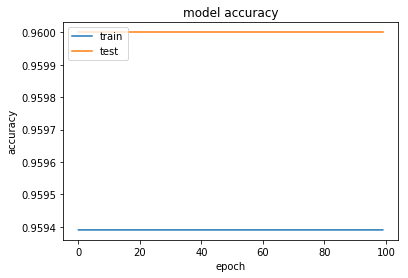

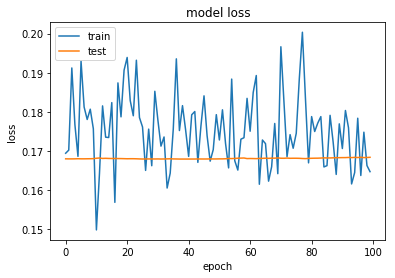

In [23]:
#summarise history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [30]:
Y.sum(0)[0] / Y.sum(0)[1] = SNRatio

0.04219409282700422